# Facebook Ad Campaign Customer Profiling 

Ensuring that the right campaign is seen by the right individuals is paramount to the success of a campaign. This is not only from a fiscal perspective but also includes the possibility to authentically engage with an audience and have a better understanding of just who they are and what gets them ticking. In order to marry the right audience and campaign, I begin with clustering the audience by the given features, namely age, gender and interests as given in the dataset.

## Data Exploration 
### Exploratory Data Analysis and Visualizations

#### Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import re
from random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn import cluster
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import pi

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV

#### Dataframe inspection

In [2]:
# Load the data in a dataframe
conversion_data = pd.read_csv('KAG_conversion_data.csv')   
conversion_data.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [3]:
# Checking for irregularities in the data
conversion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
ad_id                  1143 non-null int64
xyz_campaign_id        1143 non-null int64
fb_campaign_id         1143 non-null int64
age                    1143 non-null object
gender                 1143 non-null object
interest               1143 non-null int64
Impressions            1143 non-null int64
Clicks                 1143 non-null int64
Spent                  1143 non-null float64
Total_Conversion       1143 non-null int64
Approved_Conversion    1143 non-null int64
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


In [4]:
# Check the datatypes for the columns 
conversion_data.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [5]:
# There are as many ad ids as observations and can therefore be dropped. The same goes for the FB campaign ids
conversion_data.drop(['ad_id'], axis = 1, inplace = True)
conversion_data.drop(['fb_campaign_id'], axis = 1, inplace = True)
conversion_data.head()

,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,916,30-34,M,15,7350,1,1.43,2,1
1,916,30-34,M,16,17861,2,1.82,2,0
2,916,30-34,M,20,693,0,0.00,1,0
3,916,30-34,M,28,4259,1,1.25,1,0
4,916,30-34,M,28,4133,1,1.29,1,1


#### Gender plot

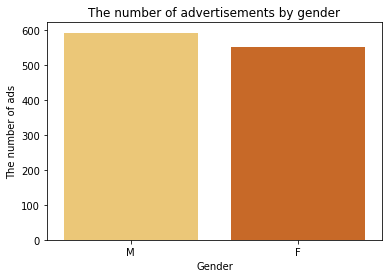

In [6]:
# Gender
gender = conversion_data['gender'].value_counts()
sns.barplot(x = gender.index, y = gender.values, palette = 'YlOrBr')
plt.xlabel('Gender')
plt.ylabel('The number of ads')
plt.title('The number of advertisements by gender')
plt.show();

In [7]:
gender = conversion_data['gender'].value_counts()
gender

M    592
F    551
Name: gender, dtype: int64

#### Age Plot

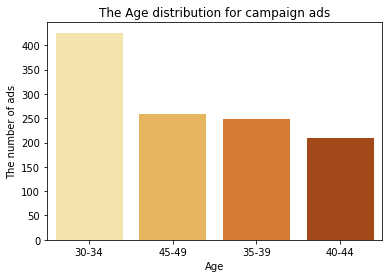

In [8]:
# Age groups 
ages = conversion_data['age'].value_counts()
sns.barplot(x = ages.index, y = ages.values, palette = 'YlOrBr')
plt.xlabel('Age')
plt.ylabel('The number of ads')
plt.title('The Age distribution for campaign ads')
plt.show();

In [9]:
ages = conversion_data['age'].value_counts()
ages.values

array([426, 259, 248, 210])

#### Campaign Advertisement Plot

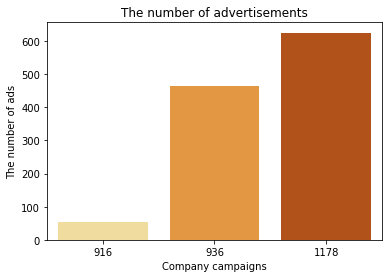

In [10]:
# Verify that viewers are being exposed to the same campaigns
ad_campaigns = conversion_data['xyz_campaign_id'].value_counts()
sns.barplot(x = ad_campaigns.index, y = ad_campaigns.values, palette = 'YlOrBr')
plt.xlabel('Company campaigns')
plt.ylabel('The number of ads')
plt.title('The number of advertisements')
plt.show();

In [11]:
ad_campaigns

1178    625
936     464
916      54
Name: xyz_campaign_id, dtype: int64

#### Viewer Interests Plot

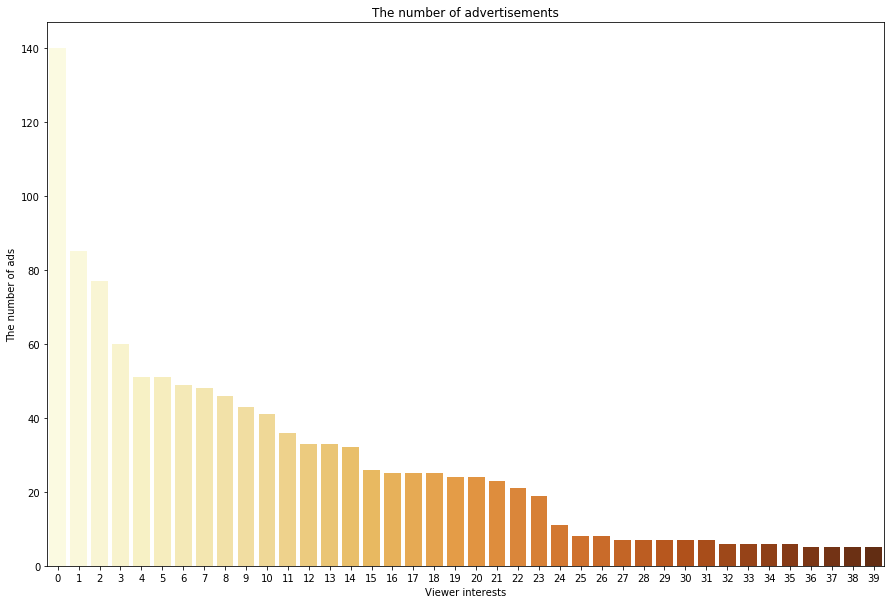

In [12]:
# Viewer interests 
viewer_interests = conversion_data['interest'].value_counts()
viewer_interests.index = list(range(len(viewer_interests)))
viewer_interests

plt.figure(figsize = (15,10))
sns.barplot(x = viewer_interests.index, y = viewer_interests.values, palette = 'YlOrBr')
plt.xlabel('Viewer interests')
plt.ylabel('The number of ads')
plt.title('The number of advertisements')
plt.show();

## Customer segmentation by Campaign

In attempts to define the ideal user profile for each campaign, I cluster the viewers by the provided features.This is to ensure that the right campaign is being seen and engaged with by the ideal client in order to gain brand awareness and ultimately result in conversions.

To do this, I use the kmeans method. The viewers are grouped by their age, gender and interests. These are all categorical values and will require some transformations first in order to be used for the kmeans clustering algorithm. In order to find the optimal value for K, I use the Within Cluster Sum of Squares distances. This is also known as the intracluster square distances - the sum distances between an observation and its cluster centroid in attempts to minimize it. The closer the observations are to the centroid of a cluster, the better the cluster.

### Data preprocessing for clustering
#### Dataframe Clean Up

In [13]:
# Label encode the campaign column
label_encoder = preprocessing.LabelEncoder()
conversion_data['xyz_campaign_id'] = label_encoder.fit_transform(conversion_data['xyz_campaign_id'])

# Label encode the gender column
conversion_data['gender'] = label_encoder.fit_transform(conversion_data['gender'])

In [14]:
def random_age_generator(age_range_string):
    '''The following function takes in a string, converts them to a list of ages and generates a random value
    in the range of the list'''
    age_range_list = [int(number) for number in re.findall(r'\w+', age_range_string)]
    age = randint(age_range_list[0], age_range_list[1])
    return age

In [15]:
# Replace the age range strings with the random values within that range for more variation in the data
conversion_data['age'] = conversion_data['age'].apply(random_age_generator)
conversion_data.head()

,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,0,30,1,15,7350,1,1.43,2,1
1,0,30,1,16,17861,2,1.82,2,0
2,0,32,1,20,693,0,0.00,1,0
3,0,30,1,28,4259,1,1.25,1,0
4,0,33,1,28,4133,1,1.29,1,1


In [16]:
# Normalize the columns needed
def scaler(dataframe, columns_to_scale):
    '''This function is used to scale the values of selected columns between 0 and 1'''
    scaler = MinMaxScaler()
    for column in columns_to_scale:
        dataframe[column] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(dataframe[column])), columns = [column])
    return dataframe

In [17]:
# Make copy of conversion_data to scale and apply kmeans
kmeans_conversion_data = conversion_data.copy()
scaler(kmeans_conversion_data, ['age', 'gender', 'interest'])

,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,0,0.000000,1.0,0.116071,7350,1,1.430000,2,1
1,0,0.000000,1.0,0.125000,17861,2,1.820000,2,0
2,0,0.105263,1.0,0.160714,693,0,0.000000,1,0
3,0,0.000000,1.0,0.232143,4259,1,1.250000,1,0
4,0,0.157895,1.0,0.232143,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...
1138,2,0.947368,0.0,0.955357,1129773,252,358.189997,13,2
1139,2,0.894737,0.0,0.964286,637549,120,173.880003,3,0
1140,2,0.947368,0.0,0.973214,151531,28,40.289999,2,0
1141,2,1.000000,0.0,0.991071,790253,135,198.710000,8,2


In [18]:
# Check the datatypes for the columns 
kmeans_conversion_data.dtypes

xyz_campaign_id          int64
age                    float64
gender                 float64
interest               float64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

### Partitional clustering: KMeans

#### Selecting the optimal K value 

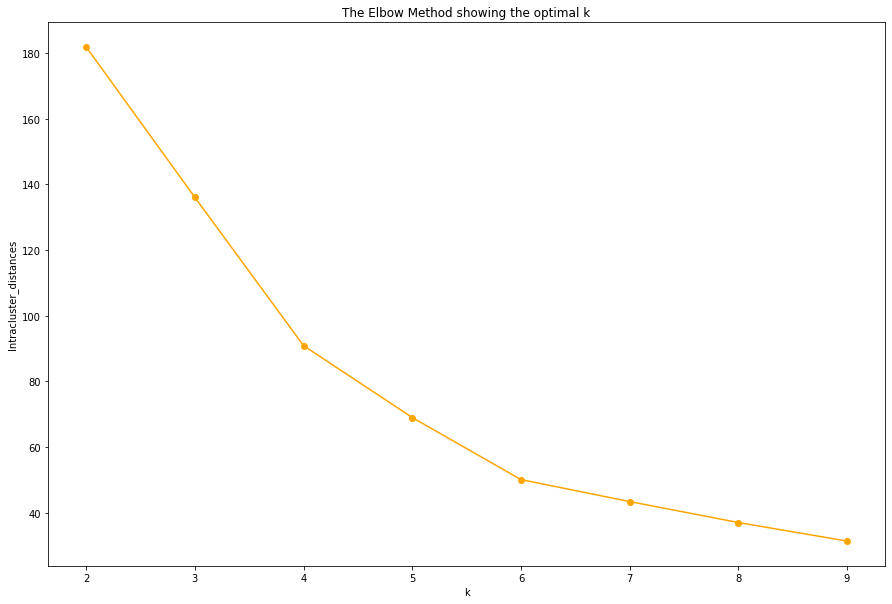

In [19]:
intracluster_distances = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(kmeans_conversion_data[['age', 'gender', 'interest']])
    intracluster_distances.append(kmeanModel.inertia_)
    
plt.figure(figsize=(15, 10))
plt.plot(K, intracluster_distances, color = 'orange', marker ='o')
plt.xlabel('k')
plt.ylabel('Intracluster_distances')
plt.title('The Elbow Method showing the optimal k')
plt.show();

It appears the optimal k value for the feautures age, gender and interests is 3. This value will be used for the number of clusters. This is the same number of campaigns observed in the dataset and alludes to the possibility that clusters may indeed be centred around the campaigns.

#### Implementing and Plotting KMeans

In [20]:
# KMeans model
k_means_model = KMeans(n_clusters = 3)
k_means_model.fit(kmeans_conversion_data[['age', 'gender', 'interest']])
kmeans_conversion_data['k_means'] = k_means_model.predict(kmeans_conversion_data[['age', 'gender', 'interest']])

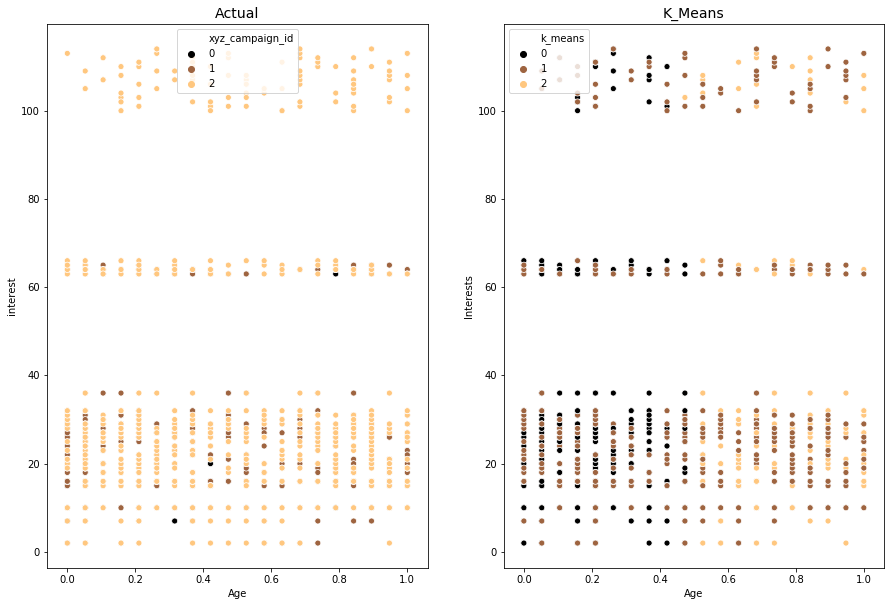

In [21]:
#Plot the predicted clusters vs the actual ones 
fig, axes = plt.subplots(1, 2, figsize=(15,10));
sns.scatterplot(kmeans_conversion_data['age'], conversion_data['interest'], hue = kmeans_conversion_data['xyz_campaign_id'], 
                palette = 'copper', ax = axes[0] );
sns.scatterplot(kmeans_conversion_data['age'], conversion_data['interest'], hue = kmeans_conversion_data['k_means'], 
         palette = 'copper', ax = axes[1]);

axes[0].set_xlabel('Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Interests')
axes[0].set_title('Actual', fontsize = 14);
axes[1].set_title('K_Means', fontsize = 14);

In the plot above it is evident that Campaign/ Cluster 2 is the most prevalent in the dataset by number of advertisements. The Actual cluster plot shows that viewer interests are the primary clustering method. The KMeans plot on the right appears to also identify a secondary clustering where majority of Campaign 0 is being viewed by an older market, namely people between the ages 45-49. Campaign 2 on the other hand attracts a younger market aged between 30-37.Campaign 1 seems to distribute quite evenly (and sparsely) across all interests and age groups. 

There appears to be distinct interest groups as well with some having a larger variance than others. This corresponds with the interest distribution plot seen earlier in the notebook. Interests labelled 0-19 seem to enjoy the largesr viewership. The variance also tells us that these are probably common interests that many people have. Interests labelled between 20-27 seem to be a very niche market with little variance. And interests labelled 28-39 seem to come in second in popularity and viewership.

#### KMeans Evaluation

In [22]:
kmeans_conversion_data.groupby('k_means').mean()

,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
k_means,,,,,,,,,
0,1.474114,0.206798,1.0,0.254039,155298.370572,19.904632,34.536948,3.081744,1.114441
1,1.466425,0.459929,0.0,0.286476,208462.517241,43.335753,62.618185,2.983666,0.898367
2,1.622222,0.779181,1.0,0.279563,184788.795556,31.031111,51.233556,2.173333,0.777778


In [23]:
kmeans_conversion_data.groupby('xyz_campaign_id').mean()

,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,k_means
xyz_campaign_id,,,,,,,,,
0,0.314815,0.648148,0.178406,8943.055556,2.092593,2.772407,1.074074,0.444444,0.648148
1,0.422868,0.448276,0.205780,17517.644397,4.275862,6.235711,1.157328,0.394397,0.849138
2,0.466274,0.558400,0.334186,327717.945600,57.708800,89.059440,4.270400,1.395200,0.915200


The k-means algorithm clusters the audience into 3 mutually exclusive groups. The viewers have shared similarities and the grouping done above attempts to create a profile for each of these groups based off of the feature combinations identified by the algorithm.

In [24]:
# Confusion Matrix for the KMeans and Campaigns 
def plot_confusion_matrix(y_campaigns, y_kmeans, classes,
                          normalize = False,
                          title = None,
                          cmap = 'YlOrBr'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    con_matrix = confusion_matrix(kmeans_conversion_data['xyz_campaign_id'], kmeans_conversion_data['k_means'],
                                  labels = y_campaigns.unique())
    
    # The labels that appear in both datasets
    classes = y_campaigns.unique()
    if normalize:
        con_matrix = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(con_matrix)

    fig, ax = plt.subplots()
    im = ax.imshow(con_matrix, interpolation='nearest', cmap = 'YlOrBr')
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(con_matrix.shape[1]),
           yticks=np.arange(con_matrix.shape[0]),
           
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Campaign labels',
           xlabel='KMeans labels')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = con_matrix.max() / 2.
    for i in range(con_matrix.shape[0]):
        for j in range(con_matrix.shape[1]):
            ax.text(j, i, format(con_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if con_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision = 2)

Confusion matrix, without normalization
[[ 27  19   8]
 [139 256  69]
 [201 276 148]]


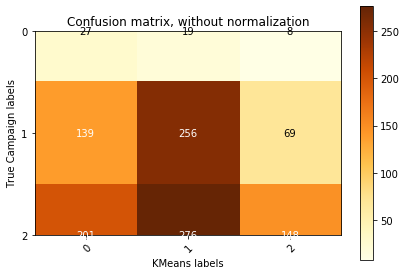

In [25]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(kmeans_conversion_data['xyz_campaign_id'], kmeans_conversion_data['k_means'], 
                      classes = kmeans_conversion_data['xyz_campaign_id'].unique(),
                      title='Confusion matrix, without normalization')
plt.show();

In [26]:
# Gather metrics about the model's performance
metrics = classification_report(kmeans_conversion_data['xyz_campaign_id'], kmeans_conversion_data['k_means'], labels = conversion_data['xyz_campaign_id'].unique())

accuracy = accuracy_score(kmeans_conversion_data['xyz_campaign_id'],
                                  kmeans_conversion_data['k_means'])

print(metrics, accuracy)

              precision    recall  f1-score   support

           0       0.07      0.50      0.13        54
           1       0.46      0.55      0.50       464
           2       0.66      0.24      0.35       625

    accuracy                           0.38      1143
   macro avg       0.40      0.43      0.33      1143
weighted avg       0.55      0.38      0.40      1143
 0.37707786526684167


The confusion matrices above an scores show that the algorithm is horribly misclassifying all 3 campaigns. The KMeans algorithm is a supervised learning model and so we do not expect this because it already knows the target values to which it should attribute the given data samples. This confirms that the customers acnnot be classified the 

### Hierarchal clustering: Complete Linkage

Again, clustering is used to try segment the viewers into 3 distinct clusters according to the running campaigns with the hopes of matching a user to a campaign and targeting them in that way.

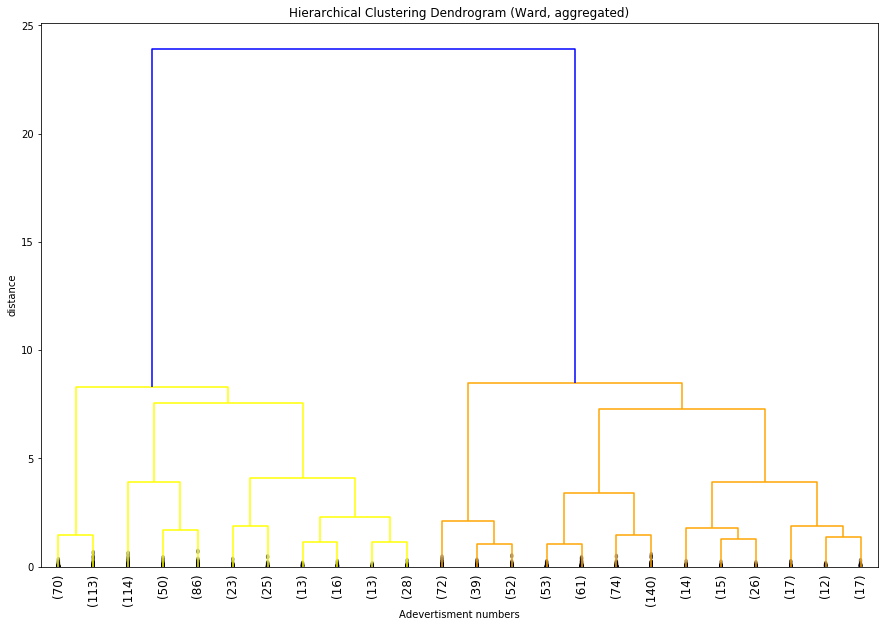

In [27]:
linkage_matrix = hierarchy.linkage(kmeans_conversion_data[['age', 'gender', 'interest']], 'ward')
hierarchy.set_link_color_palette(['yellow', 'orange'])

figure = plt.figure(figsize=(15, 10))
hierarchy.dendrogram(linkage_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p = 24,  # show only the last p merged clusters
    leaf_rotation = 90,
    leaf_font_size = 12,
    show_contracted = True,  # to get a distribution impression in truncated branches
)

plt.title('Hierarchical Clustering Dendrogram (Ward, aggregated)')
plt.xlabel('Adevertisment numbers')
plt.ylabel('distance')
plt.show()

## Campaign Features and Metrics


### Campaign Feature Analysis

In [36]:
# Make copy of conversion_data to scale and apply kmeans
plotting_conversion_data = conversion_data.copy()
plotting_conversion_data = scaler(plotting_conversion_data, ['Impressions', 'Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion'])
plotting_conversion_data.head()

,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,0,30,1,15,0.002380,0.002375,0.002235,0.033333,0.047619
1,0,30,1,16,0.005824,0.004751,0.002844,0.033333,0.000000
2,0,32,1,20,0.000199,0.000000,0.000000,0.016667,0.000000
3,0,30,1,28,0.001367,0.002375,0.001953,0.016667,0.000000
4,0,33,1,28,0.001326,0.002375,0.002016,0.016667,0.047619


In [37]:
def feature_sum(type_string, campaign_id):
    '''The following function is used to calculate the sum conversions for each campaign'''
    feature_sum = round(plotting_conversion_data[type_string].loc[(plotting_conversion_data['xyz_campaign_id'] == campaign_id)].sum(), 2)
    return feature_sum

In [60]:
def bar_count(campaign_names):
    for bars in campaign_names:
        count = bars.get_height()
        plt.text(bars.get_x(), count + 0.5, count)

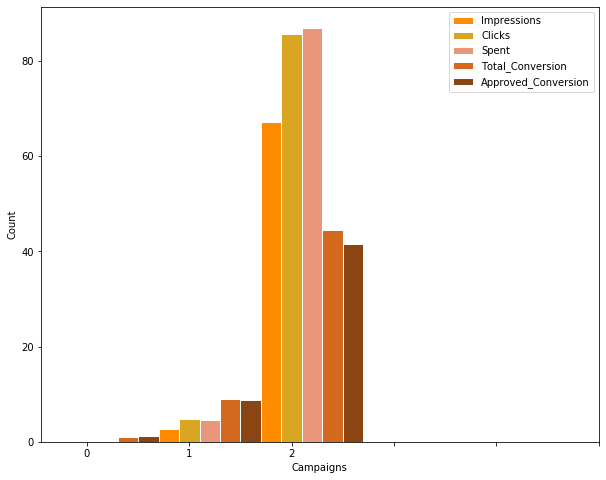

In [63]:
# Campaign_metrics_plot
    
# Create an empty dictionary in which to store the feature sums for each campaign
feature_sums = {}

campaign_ids = [0, 1, 2]
for i_d in campaign_ids:

    # Loop through the given list and apply the feature_sum function to each function
    features_list = ['Impressions', 'Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion']
    features_sum_list = [feature_sum(feature, i_d) for feature in features_list]

    feature_sums[str(i_d)] = features_sum_list

# Bar positions
bar_width = 0.2
x1 = np.arange(3)
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]
x4 = [x + bar_width for x in x3]
x5 = [x + bar_width for x in x4]

sums_df = pd.DataFrame(data = feature_sums)
sums_df.columns = ['Campaign 0', 'Campaign 1', 'Campaign 2']
sums_df['Colours'] = ['darkorange', 'goldenrod', 'darksalmon','chocolate', 'saddlebrown']
sums_df['X_ticks'] = [x1, x2, x3, x4, x5]
sums_df['Labels'] = ['Impressions', 'Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion']

# Plot Campaign metrics
plt.figure(figsize = (10, 8))
for index in sums_df.index:
    plt.bar(sums_df['X_ticks'][index], 
    sums_df[['Campaign 0', 'Campaign 1', 'Campaign 2']].iloc[index], 
    width = bar_width,
    color = sums_df['Colours'][index], 
    edgecolor = 'white', 
    label = sums_df['Labels'][index])
    
# Add xticks in the middle of the grouped bars
plt.xlabel('Campaigns')
plt.ylabel('Count')
plt.xticks([x + bar_width  for x in range(len(sums_df.iloc[4]))], ['0', '1', '2'])

# Create legend & Show graphic
plt.legend()
plt.show();

In [53]:
sums_df.head()

,Campaign 0,Campaign 1,Campaign 2,Colours,X_ticks,Labels
0,0.16,2.65,67.10,darkorange,"[0, 1, 2]",Impressions
1,0.27,4.71,85.67,goldenrod,"[0.2, 1.2, 2.2]",Clicks
2,0.23,4.52,86.98,darksalmon,"[0.4, 1.4, 2.4000000000000004]",Spent
3,0.97,8.95,44.48,chocolate,"[0.6000000000000001, 1.5999999999999999, 2.600...",Total_Conversion
4,1.14,8.71,41.52,saddlebrown,"[0.8, 1.7999999999999998, 2.8000000000000007]",Approved_Conversion


The relationship between the impressions, clicks, spend and conversions is plotted above. The feature counts had to be scaled due to the vast differences in total sums. From the plot above, these differences in total sums can be sobserved even after scaling. The more the impressions and clicks, the more money is spent on the ad. Also, there is a slight drop from the total conversions to total conversions, which is understandable considering that customer curiosity does not always result in a purchase. 

This pattern is consistent throughout all three campaigns. However, what is interesting to observe is that campaigns 0 and 1 follow the pattern and result in both total and approved conversions being higher in count than the impressions, clicks and spend. Campaign 2, which is the campaign with the largest number of ads in its adset and therefore the largest number of clicks, does not follow the pattern and sees a significant decline in conversions. There could be various reasons for this including the possibility of over-saturation that results in a disinterest from the customers. The creative, which I do not have access to in this analysis, could also be playing a role. Clearly, it is enough to generate clicks and takes up a large part of the company's spend budget.

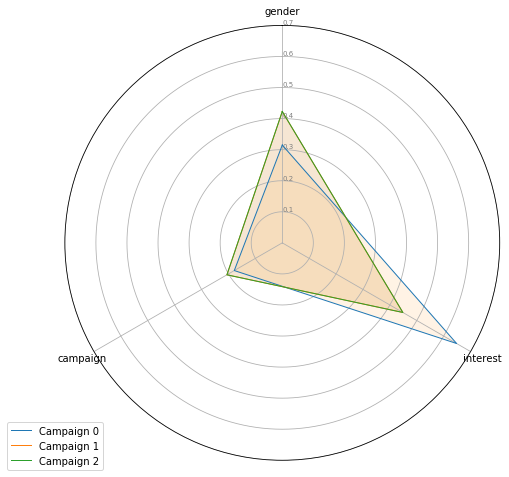

In [64]:
# Radar Plot for Features 

# Set data
features = []
for i_d in range(3):
    campaign_features = {}
    campaign_features['age'] =  kmeans_conversion_data['age'].loc[(kmeans_conversion_data['xyz_campaign_id'] == i_d)].mean()
    campaign_features['gender'] = kmeans_conversion_data['gender'].loc[(kmeans_conversion_data['xyz_campaign_id'] == i_d)].mean()
    campaign_features['interest'] = kmeans_conversion_data['interest'].loc[(kmeans_conversion_data['xyz_campaign_id'] == i_d)].mean()
    features.append(dict(campaign_features))
    
# Create dataframe
features_df = pd.DataFrame(features)
features_df['campaign'] = ['0', '1', '2']

# Create background
# number of variable
categories = list(features_df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.figure(figsize = (10, 8))
ax = plt.subplot(111, polar = True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], ["0.1","0.2","0.3", "0.4", "0.5", "0.6", "0.7"], color = "grey", size = 7)
plt.ylim(0, 0.7)
 
# Plot each individual = each line of the data

# Ind1
values = features_df.loc[0].drop('campaign').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = "Campaign 0");
ax.fill(angles, values, 'darkorange', alpha = 0.1)
 
# Ind2
values = features_df.loc[1].drop('campaign').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = "Campaign 1");
ax.fill(angles, values, 'goldenrod', alpha = 0.1)

# Ind3
values = features_df.loc[1].drop('campaign').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth = 1, linestyle = 'solid', label = "Campaign 2");
ax.fill(angles, values, 'chocolate', alpha = 0.1)
 
# Add legend
plt.legend(loc = 'upper right', bbox_to_anchor=(0.1, 0.1));

## Campaign Metrics

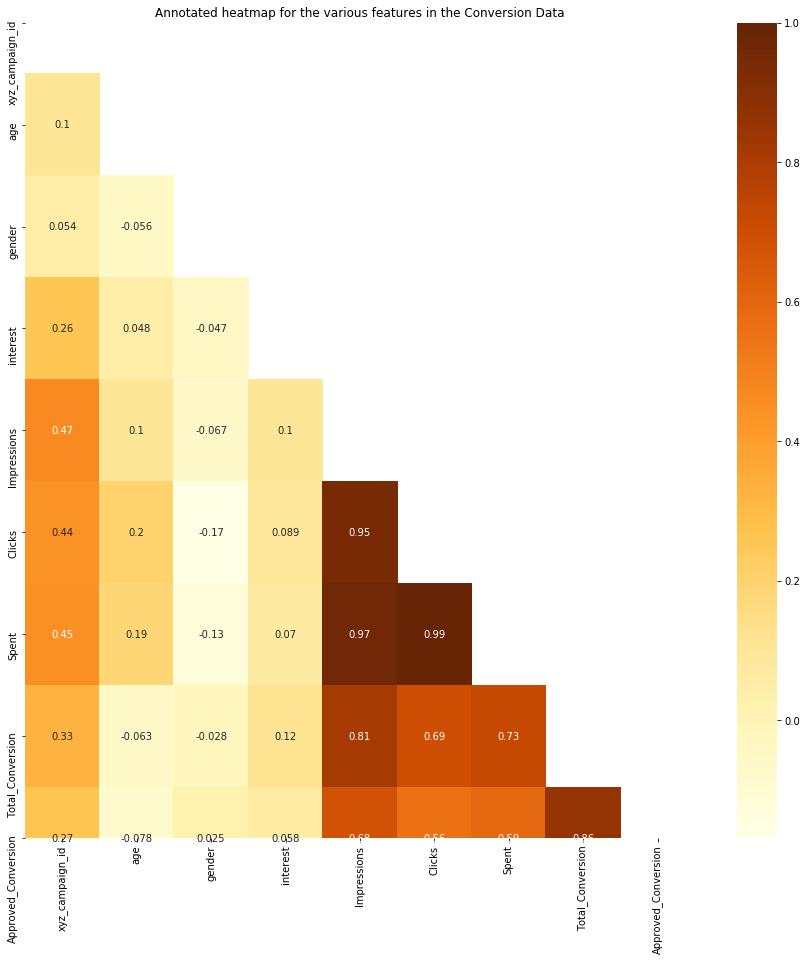

In [65]:
# A heatmap showing the correlation between features
plt.figure(figsize = (15, 15))
plt.title('Annotated heatmap for the various features in the Conversion Data')

mask = np.zeros(conversion_data.corr().shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(conversion_data.corr(), annot = True, mask = mask, cmap = 'YlOrBr');

In [72]:
# Derive new features by which to meausre the return on investment made by the company on advertising campaigns
# KPIs: Feature engineering in order to derive camapaign success metrics 

def campaign_impressions_cost(campaign_id):
    '''The function below calculates how many times a campaign is seen and how much that costs'''
    campaign = plotting_conversion_data.loc[plotting_conversion_data['xyz_campaign_id'] == campaign_id]
    campaign_impressions = campaign['Impressions'].sum()
    campaign_impression_cost = (campaign['Spent'].sum() / campaign_impressions) * 1000 # measured every 1000 impressions
    return campaign_impression_cost

def click_through_rate(campaign_id):
    '''The following function calculates the click through rate of a campaign - how many viewers engaged with
    the content of the campaign'''
    campaign = plotting_conversion_data.loc[plotting_conversion_data['xyz_campaign_id'] == campaign_id]
    campaign_ctr = (campaign['Clicks'].sum()/ campaign['Impressions'].sum())*100
    return campaign_ctr

def cost_per_click(campaign_id):
    '''The following function calculates the money spent to get a viewer to engage with the content'''
    campaign = plotting_conversion_data.loc[plotting_conversion_data['xyz_campaign_id'] == campaign_id]
    campaign_cpc = campaign['Spent'].sum()/ campaign['Clicks'].sum()
    return campaign_cpc

def conversion_rate(campaign_id):
    '''The following function calculates how many clicks per campaign result in both total and approved 
    conversions'''
    campaign = plotting_conversion_data.loc[plotting_conversion_data['xyz_campaign_id'] == campaign_id]
    campaign_approved_cr = campaign['Spent'].sum()/ campaign['Approved_Conversion'].sum()
    campaign_total_cr = campaign['Spent'].sum()/ campaign['Total_Conversion'].sum()
    return campaign_approved_cr

def conversion_loss(campaign_id):
    '''The following function calculates the loss of viewers between a total conversion and an approved one'''
    campaign = plotting_conversion_data.loc[plotting_conversion_data['xyz_campaign_id'] == campaign_id]
    campaign_conversion_loss = np.sum(campaign['Total_Conversion'] - campaign['Approved_Conversion'])
    loss_rate = (campaign_conversion_loss / len(campaign)) 
    return loss_rate

In [73]:
campaign_ids = range(3)
campaigns = []
for i_d in campaign_ids:
    campaign_kpa = {}
    campaign_kpa['campaign_impressions_cost'] = campaign_impressions_cost(i_d)
    campaign_kpa['click_through_rate'] = click_through_rate(i_d)
    campaign_kpa['cost_per_click'] = cost_per_click(i_d)
    campaign_kpa['conversion_rate'] = conversion_rate(i_d)
    campaign_kpa['conversion_loss'] = conversion_loss(i_d)
    campaigns.append(dict(campaign_kpa))

In [75]:
# Convert dictionary to dataframe
campaign_kpa_df = pd.DataFrame(data = campaigns)
campaign_kpa_df

,campaign_impressions_cost,click_through_rate,cost_per_click,conversion_rate,conversion_loss
0,1492.943094,171.291113,0.871582,0.204698,-0.003263
1,1706.078792,177.828238,0.959397,0.518831,0.000508
2,1296.347929,127.687272,1.015252,2.094675,0.004735


The key performance indicators for the campaigns are telling. The campaign with the highest impression cost is campaign 1 which is also the campaign with the second largest number of ads in its adset. This means for a smaller number of ads seen, it costs more to for each ad to be seen on average. This campaign also has the highest click-through rate which implies that the spenditure for impressions may be worth it. Campaign 1 presents the highest conversion retention from the total conversions to the approved ones. This means that customers who engage and inquire about ads from this campaign often end up making a purchase as well.  

Campaign 0 has the least amount of ads in its adset and yet has the second highest impression cost, click through rate and cost per click. This means campaign 0 ads cost more to be seen. The campaign also has the lowest conversion rate as compared to the other campaigns(probably due to the few number of ads) but has a negative conversion. This means that the approved conversions(purchases) are more than the total conversions(inquires). This alludes to the possibility of the product advertised being quite well known. The ads for it are minimal but a good click through rate is observed and the product is being purchased with minimal inquiries made first. The creative content for the ad may also be outstanding regardless of the number of ads seen.

Campaign 2 has the largest of ads in its adset, hence the lowest impression cost. However, it also has the lowest click through rate and this raises questions about why-is the content not strong enough or are there too many ads in rotation? It also has the highest cost per click and conversion rate. The campaign also has the highest conversion loss from total conversions to approved conversions. 

It is also important to note that due to the initial differences in number of ads per campaign, the comparisons may be slightly skewed.

## How well can I predict an approved conversion?

### XGBoost

In [84]:
# How many non_converts are there for each campaign?
no_conversion = conversion_data[conversion_data['Approved_Conversion'] == 0]
for i_d in range(3):
    campaign_0_non_conversions = no_conversion[no_conversion['xyz_campaign_id'] == i_d]
    print(f'{i_d}:{len(campaign_0_non_conversions)}')

0:30
1:292
2:237


In [85]:
# Normalize the data 
model_conversion_data = conversion_data.copy()
# model_conversion_data = scaler(model_conversion_data, ['age', 'gender', 'interest', 'Impressions', 'Clicks', 'Total_Conversion', 'Approved_Conversion'])

# One hot enncode campaigns
one_hot_encoded_campaigns = pd.get_dummies(model_conversion_data['xyz_campaign_id'])
campaign_values = one_hot_encoded_campaigns.values
model_conversion_data['campaign 0'] = campaign_values[:, 0]
model_conversion_data['campaign 1'] = campaign_values[:, 1]
model_conversion_data['campaign 2'] = campaign_values[:, 2]


# Drop campaign column 
model_conversion_data = model_conversion_data.drop(['xyz_campaign_id'], axis = 1)

# Convert to int type or models give value error: continuous is not supported
model_conversion_data = model_conversion_data.astype('int64')

# model_conversion_data.info()

# Set X and y variables
X = model_conversion_data.drop(['Total_Conversion','Approved_Conversion'], axis = 1)
y = model_conversion_data['Approved_Conversion']

In [87]:
# The data is split for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [88]:
# XGB model
xgb_clf = xgb.XGBClassifier(random_state = 0, learning_rate = 0.01).fit(X_train, y_train)
xgb_predictions = xgb_clf.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)

In [89]:
xgb_accuracy

0.5478260869565217

### Logistic Regression

In [90]:
# Logistic Regression model
log_reg_clf = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000).fit(X_train, y_train)
log_reg_predictions = log_reg_clf.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [91]:
log_reg_accuracy

0.5826086956521739

### Logistic Regression with Cross Validation

In [92]:
log_reg_cv_clf = LogisticRegressionCV(cv = 5, random_state=0).fit(X_train, y_train)
log_reg_cv_predictions = log_reg_cv_clf.predict(X_test)
log_reg_cv_accuracy = accuracy_score(y_test, log_reg_cv_predictions)

/Users/dimphomashile/opt/anaconda3/envs/akademy.ai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/dimphomashile/opt/anaconda3/envs/akademy.ai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/dimphomashile/opt/anaconda3/envs/akademy.ai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/dimphomashile/opt/anaconda3/envs/akademy.ai/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase

In [97]:
log_reg_cv_accuracy

0.5217391304347826

### SVM

In [93]:
# SVM Model
svm_clf = svm.SVC().fit(X_train, y_train)
svm_clf_predictions = svm_clf.predict(X_test)
svm_clf_accuracy = accuracy_score(y_test, svm_clf_predictions)

/Users/dimphomashile/opt/anaconda3/envs/akademy.ai/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [94]:
svm_clf_accuracy

0.4956521739130435

In [95]:
model_accuracies = {'logistic regression': 57.4, 'logistic regression with cross validation': 49.6, 
                    'SVM': 49.6, 'XGB': 55.7}

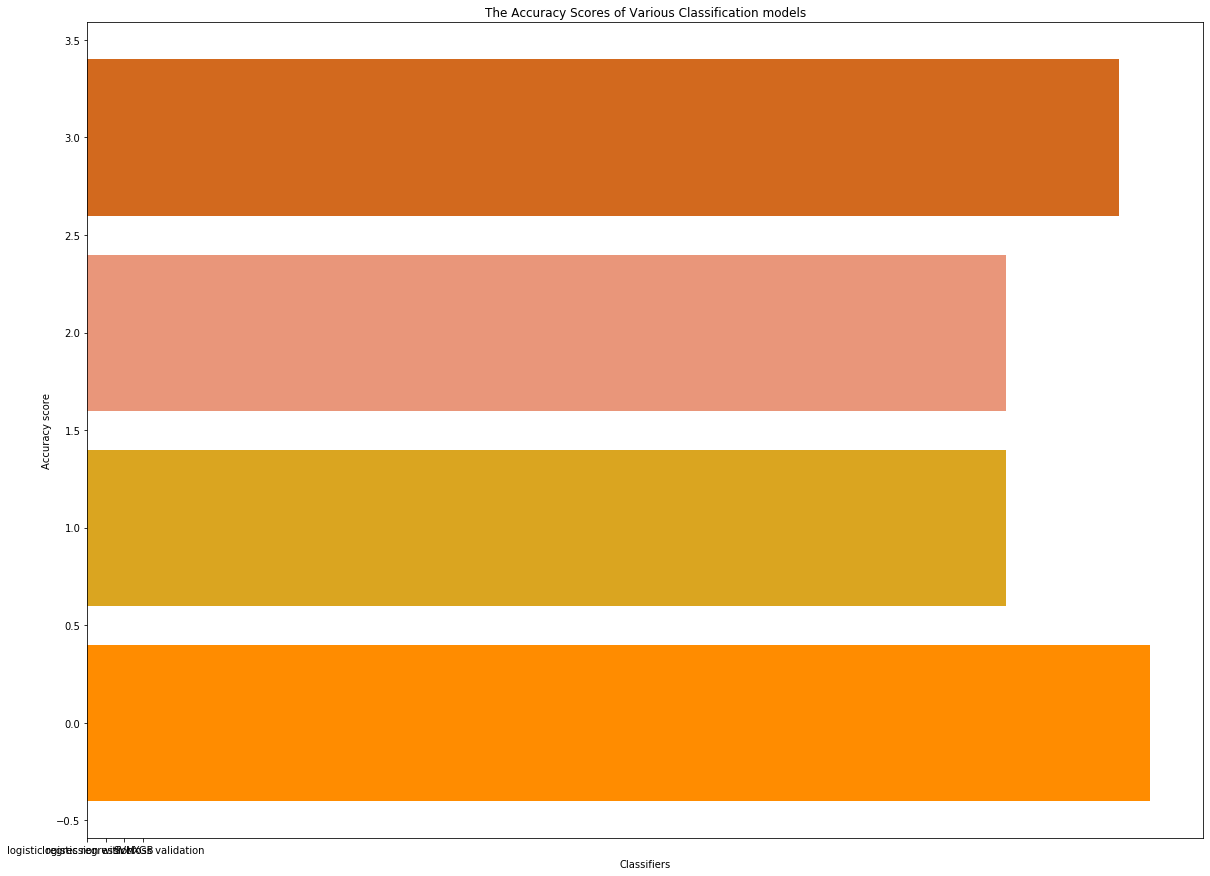

In [96]:
plt.figure(figsize = (20, 15))
plt.barh(range(len(model_accuracies)), list(model_accuracies.values()), align = 'center', 
        color = ['darkorange', 'goldenrod', 'darksalmon', 'chocolate'])
plt.xticks(range(len(model_accuracies)), list(model_accuracies.keys()))
plt.title('The Accuracy Scores of Various Classification models')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy score')
plt.show()